In [7]:
import os
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
from os.path import join, exists
from os import listdir
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
%matplotlib notebook

In [2]:
def read_tensorboard_log(path):
    # Loading too much data is slow...
    tf_size_guidance = {
        'distributions': 1,
        'images': 0,
        'scalars': 1000,
        'histograms': 1,
        'tensors': 1000,
    }
    event_acc = EventAccumulator(path, tf_size_guidance)
    event_acc.Reload()
    return event_acc

def scalar_to_numpy(event_acc, tag_name):
    scalar = event_acc.Scalars(tag_name)
    return np.array([x[2] for x in scalar])

def data_from_tensorboard_log(path):
    tf.logging.set_verbosity(tf.logging.ERROR)
    event_acc = read_tensorboard_log(path)
    scalar_tags = event_acc.Tags()['scalars']
    results = {}
    for tag in scalar_tags:
        results[tag] = scalar_to_numpy(event_acc, tag)
    return results

def get_all_runs(exp_dir):
    results = {}
    for sub_dir in listdir(exp_dir):
        results[sub_dir] = data_from_tensorboard_log(join(exp_dir, sub_dir))
    return results

def get_all_results(root_dir):
    results = {}
    for sub_dir in listdir(root_dir):
        results[sub_dir] = get_all_runs(join(root_dir, sub_dir))
    return results

def tb_data_to_pandas(tb_dir, output_file):
    tb_data = get_all_results(tb_dir)
    df = pd.DataFrame(tb_data)
    df.to_pickle(output_file)

In [3]:
def read_set_results(set_name):
    df_dir_ = '../../results'
    tb_dir_ = f'../../out/{set_name}/tensorboard'
    df_file_ = f'{df_dir_}/{set_name}_results.pkl'
    os.makedirs(df_dir_, exist_ok=True)
    if not exists(df_file_):
        tb_data_to_pandas(tb_dir_, df_file_)
    return pd.read_pickle(df_file_)

def read_full_test_results(set_name):
    file_path = f'../../results/{set_name}_test_results.pkl'
    with open(file_path, 'rb') as f:
        res_dict = pickle.load(f)
        assert isinstance(res_dict, dict)
    return res_dict

def flatten_test_results(test_results: dict, group_names: list):
    output = {}
    for g in group_names:
        output[g] = []
        for t in test_results:
            if t.startswith(g):
                res = test_results[t]
                output[g].append(res)
        output[g] = np.array(output[g])
    return output

In [22]:
def compare_test_results(set_name, exp_filter=None, conf_intervals=True, colors=None, highest=False):
    if colors is None:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
    set_results = read_set_results(set_name)
    if exp_filter is None:
        exp_filter = set_results.keys()
    plt.figure(figsize=(9,5))
    for i, k in enumerate(set_results):
        if k not in exp_filter:
            continue
        exp_results = set_results[k]
        test_mean_reward = [x['test_mean_reward'] for x in exp_results]
        test_mean_reward = np.array(test_mean_reward)
        x = np.arange(test_mean_reward.shape[1])
        sem = scipy.stats.sem(test_mean_reward, axis=0)
        conf95 = 1.96 * sem
        stdev = test_mean_reward.std(axis=0)
        mu = test_mean_reward.mean(axis=0)
        if highest:
            y = test_mean_reward.max(axis=0)
        else:
            y = mu
        plt.plot(x, y, color=colors[i])
        if conf_intervals:
            plt.fill_between(x, mu-conf95, mu+conf95, alpha=0.4, color=colors[i])
    plt.grid()
    title = 'Test performance' + (' (95% confidence interval shaded)' if conf_intervals else '')
    plt.title(title)
    plt.ylabel(f'{"Highest" if highest else "Mean"} reward per episode')
    plt.xlabel('Test iteration during training')
    plt.legend([k for k in set_results.keys() if k in exp_filter])
    
def plot_rewards_by_mass(runs, resample=True, color='b', marker_cycle=['o'], color_cycle=None, cycle_len=None):
    if resample and runs.shape[0] > 300:
        assert cycle_len is None
        idx = np.random.choice(runs.shape[0], 300, replace=False)
        runs = runs[idx]
    plt.figure(figsize=(9,5))
    plt.ylim(-2030, 70)
    plt.xlim(-0.05, 1.80)
    plt.ylabel('Reward per episode')
    plt.xlabel('Sampled pendulum mass')
    plt.title('Test performance by mass')
    # [".", "^", "*"]
    if cycle_len is not None:
        cycle_len = int(cycle_len)
        m_i = 0
        for i in range(0, runs.shape[0], cycle_len):
            j = max(i + cycle_len, runs.shape[0])
            marker = marker_cycle[m_i % len(marker_cycle)]
            if color_cycle is not None:
               color = color_cycle[m_i % len(color_cycle)]
            m_i += 1
            plt.scatter(runs[i:j, 2], runs[i:j, 3], marker=marker, facecolors=color, edgecolors=color, alpha=0.5)
    else:
        plt.scatter(runs[:, 2], runs[:, 3], facecolors=color, edgecolors=color, alpha=0.5)
    plt.show()

# Experiments (set 5)

### Data

In [5]:
set5_results = read_set_results('set5')
set5_test_results = read_full_test_results('set5')
set5_test_results = flatten_test_results(set5_test_results, set5_results.keys())
# dims are: mass_mean_param, mass_stdev_param, sampled_mass, episode_reward
set5_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Overview

<IPython.core.display.Javascript object>


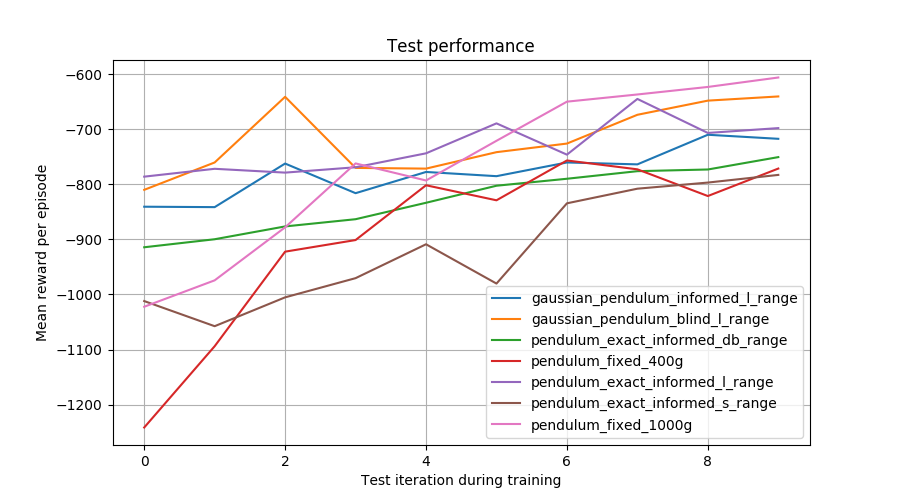

In [8]:
compare_test_results('set5', conf_intervals=False)

---
### *Blind* pendulum vs *perfectly informed*
- Blind pendulum trained with:
```
mass_mean: (0.050, 1.200)
mass_stdev: (0.010, 0.150)
input: [pos_x, pos_y, ang_vel]
```
- Perfectly informed pendulum trained with:
```
mass_mean: (0.050, 1.200)
mass_stdev: 0.0
input: [pos_x, pos_y, ang_vel, exact_mass]
```

<IPython.core.display.Javascript object>


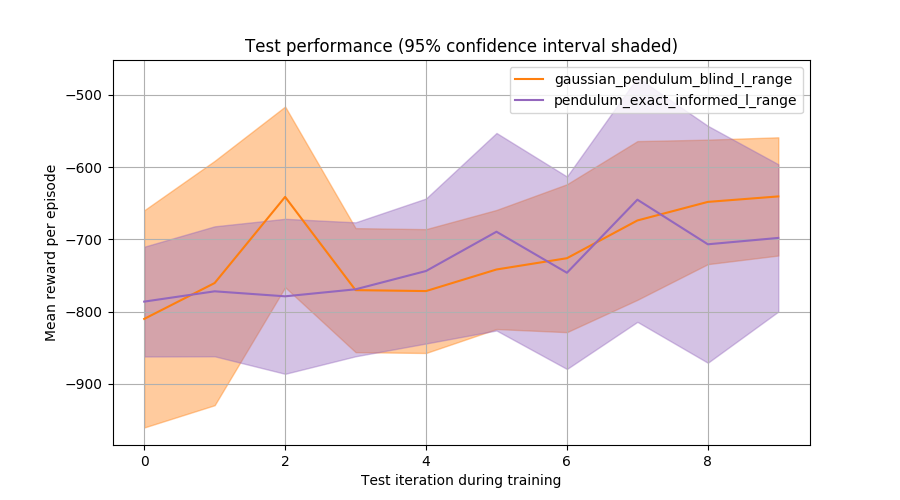

In [145]:
compare_test_results('set5', [
    'gaussian_pendulum_blind_l_range',
    'pendulum_exact_informed_l_range'
])

---
### *Blind* pendulum vs *informed*
- Blind pendulum trained with:
```
mass_mean: (0.050, 1.200)
mass_stdev: (0.010, 0.150)
input: [pos_x, pos_y, ang_vel]
```
- Informed pendulum trained with:
```
mass_mean: (0.050, 1.200)
mass_stdev: (0.010, 0.150)
input: [pos_x, pos_y, ang_vel, mass_mean, mass_stdev]
```

<IPython.core.display.Javascript object>


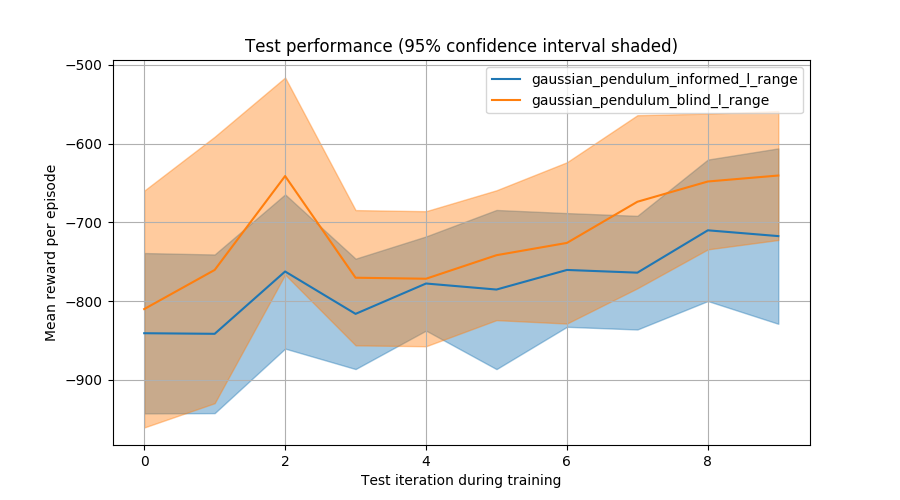

In [9]:
compare_test_results('set5', [
    'gaussian_pendulum_blind_l_range',
    'gaussian_pendulum_informed_l_range'
])

---
### *Blind* pendulum vs *fixed*
- Blind pendulum trained with:
```
mass_mean: (0.050, 1.200)
mass_stdev: (0.010, 0.150)
input: [pos_x, pos_y, ang_vel]
```
- Fixed pendulum trained with:
```
mass_mean: 1.000
mass_stdev: 0.0
input: [pos_x, pos_y, ang_vel]
```

<IPython.core.display.Javascript object>


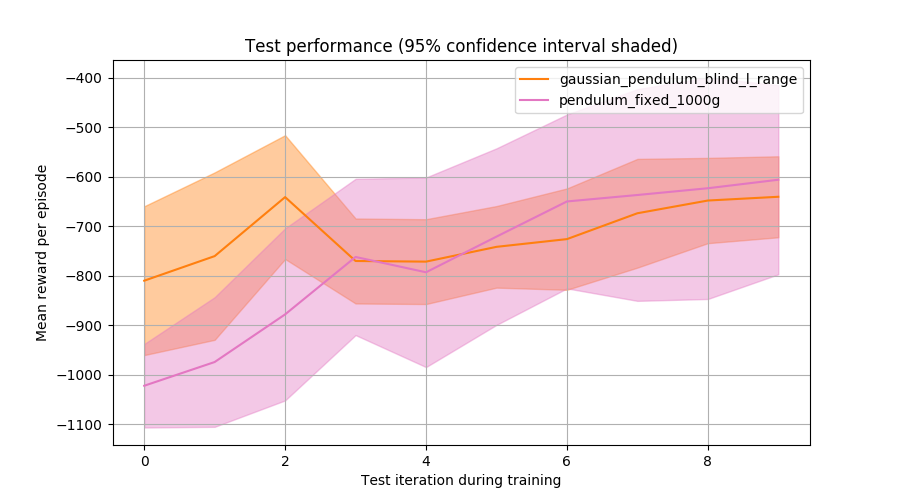

In [10]:
compare_test_results('set5', [
    'gaussian_pendulum_blind_l_range',
    'pendulum_fixed_1000g'
])

---
### *Perfectly informed* pendulums with different mass ranges
- Perfectly informed pendulum (small range) trained with:
```
mass_mean: (0.050, 0.400)
mass_stdev: 0.0
input: [pos_x, pos_y, ang_vel, exact_mass]
```
- Perfectly informed pendulum (large range) trained with:
```
mass_mean: (0.050, 1.200)
mass_stdev: 0.0
input: [pos_x, pos_y, ang_vel, exact_mass]
```

<IPython.core.display.Javascript object>


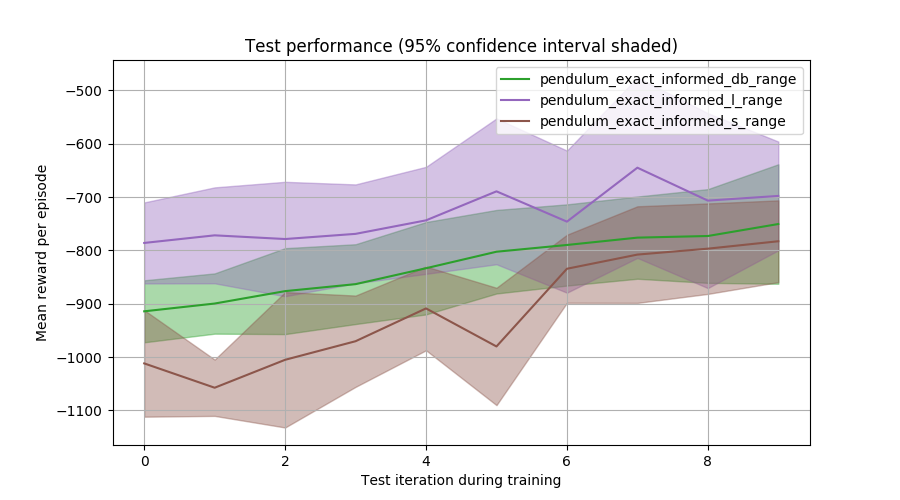

In [11]:
compare_test_results('set5', [
    'pendulum_exact_informed_s_range',
    'pendulum_exact_informed_l_range',
    'pendulum_exact_informed_db_range',
])

---
### Test performance by mass

<IPython.core.display.Javascript object>


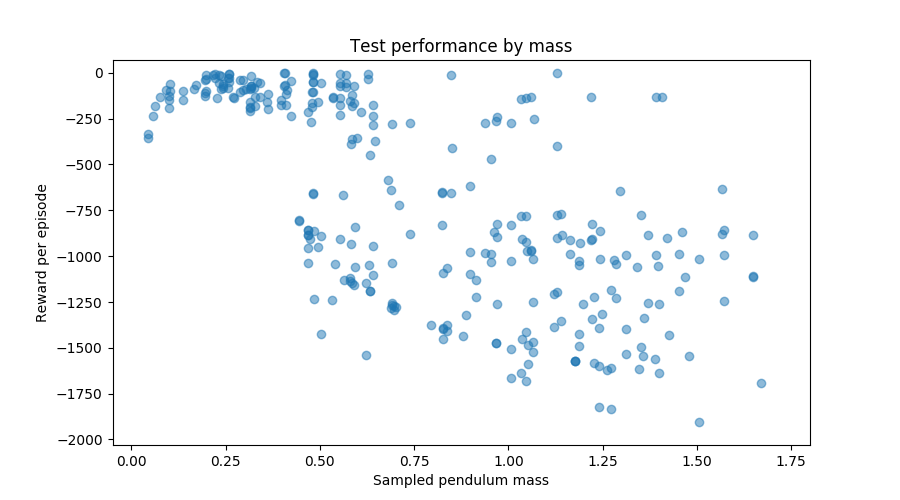

gaussian_pendulum_informed_l_range


<IPython.core.display.Javascript object>


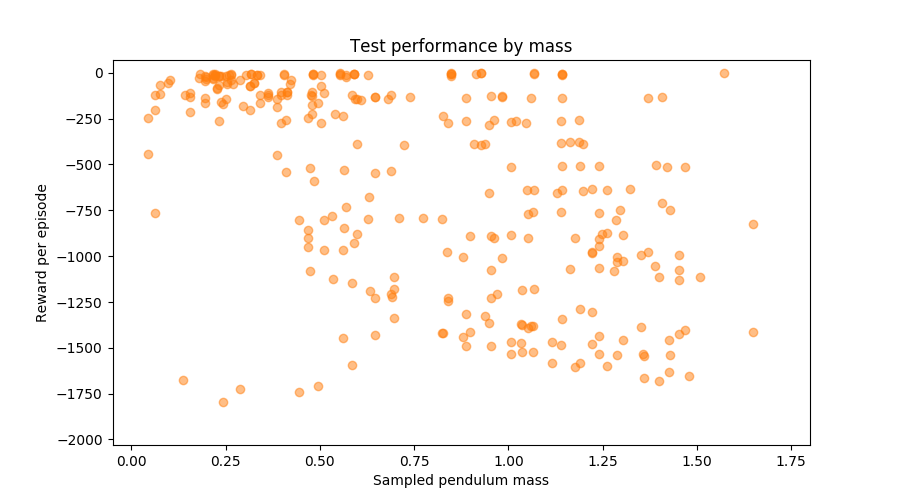

gaussian_pendulum_blind_l_range


<IPython.core.display.Javascript object>


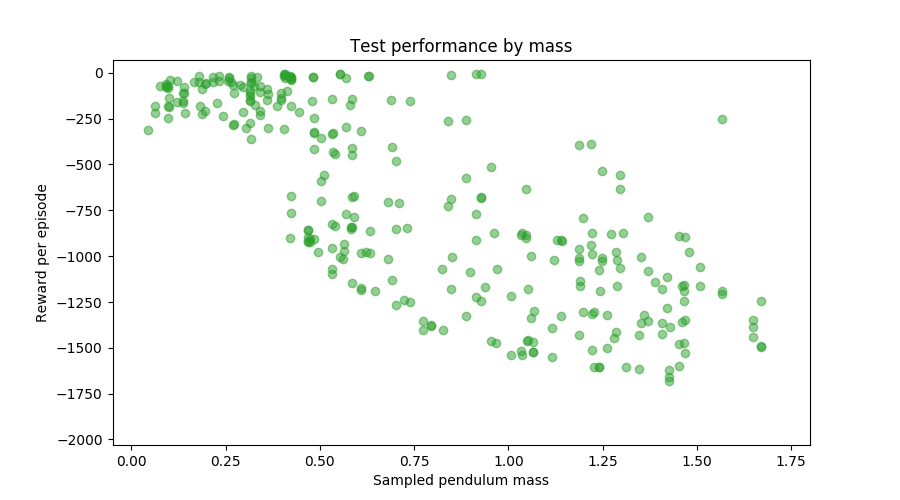

pendulum_exact_informed_db_range


<IPython.core.display.Javascript object>


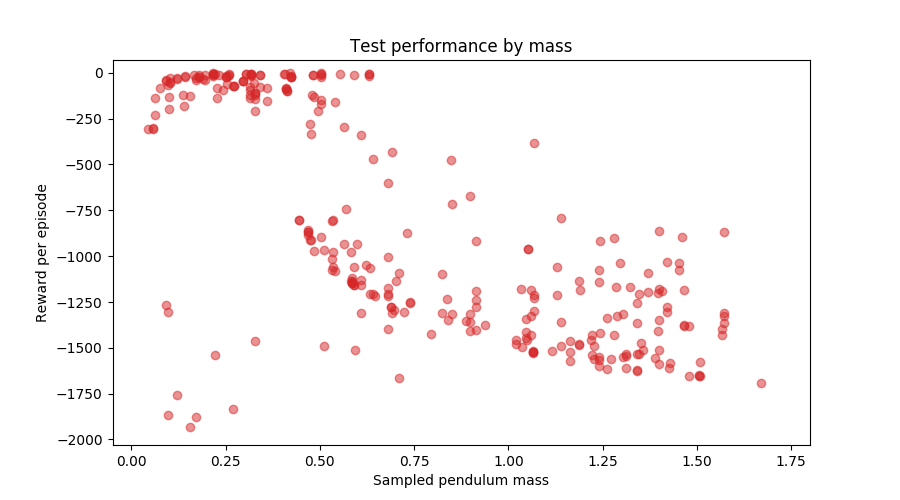

pendulum_fixed_400g


<IPython.core.display.Javascript object>


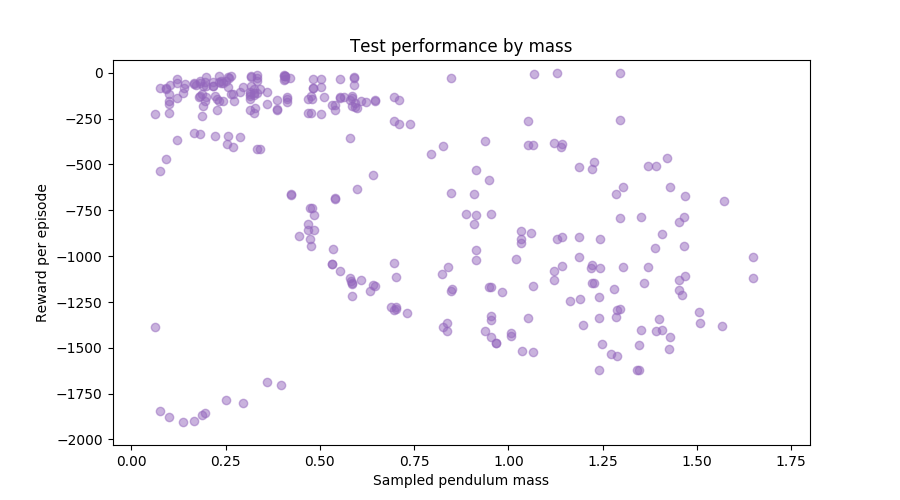

pendulum_exact_informed_l_range


<IPython.core.display.Javascript object>


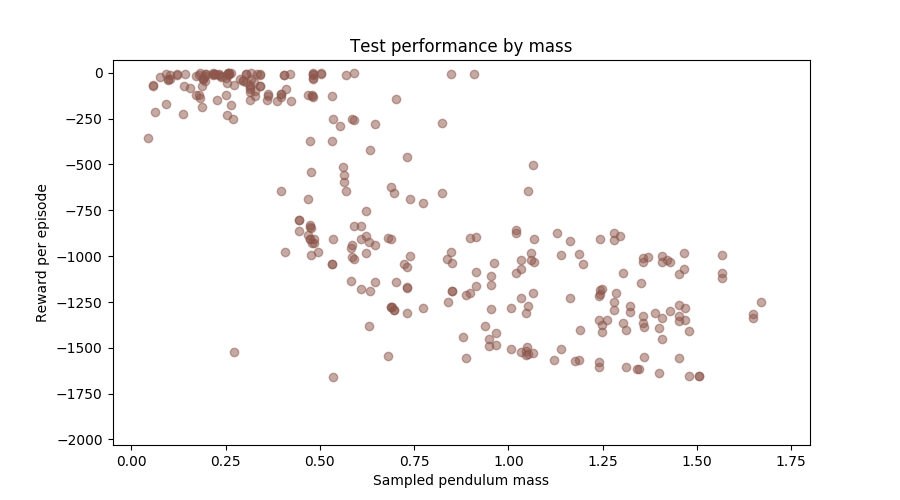

pendulum_exact_informed_s_range


<IPython.core.display.Javascript object>


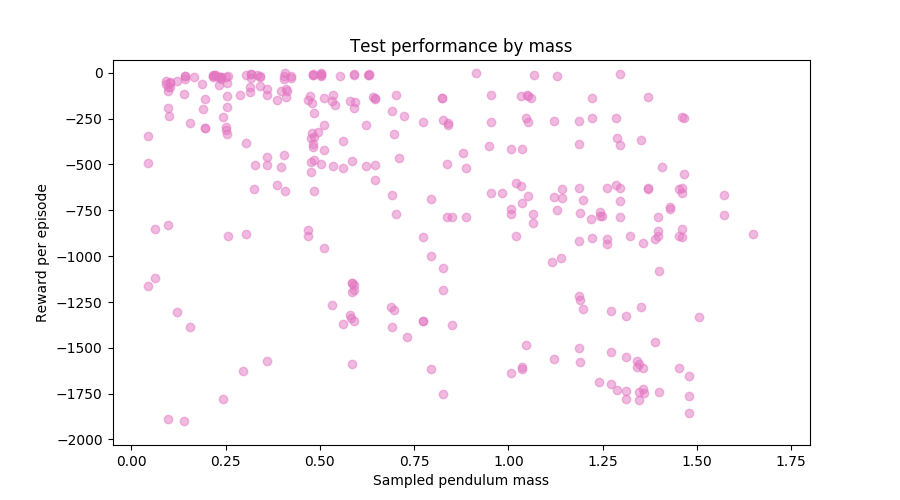

pendulum_fixed_1000g


In [25]:
for i, k in enumerate(set5_results.keys()):
    plot_rewards_by_mass(set5_test_results[k].reshape(-1, 4), color=set5_colors[i])
    print(k)

---

# Experiments (set 6)

### Data

In [13]:
set6_results = read_set_results('set6')
set6_test_results = read_full_test_results('set6')
set6_test_results = flatten_test_results(set6_test_results, set6_results.keys())
# dims are: mass_mean_param, mass_stdev_param, sampled_mass, episode_reward
set6_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Overview

<IPython.core.display.Javascript object>


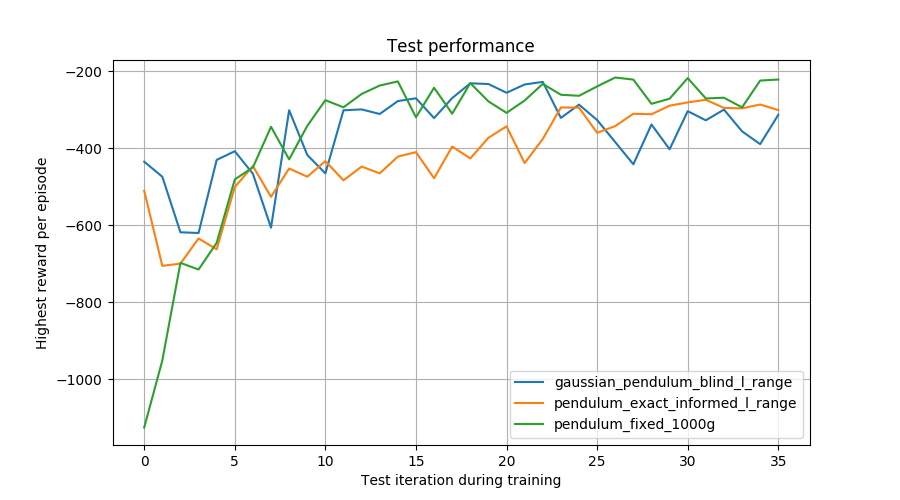

In [14]:
compare_test_results('set6', conf_intervals=False, highest=True)

<IPython.core.display.Javascript object>


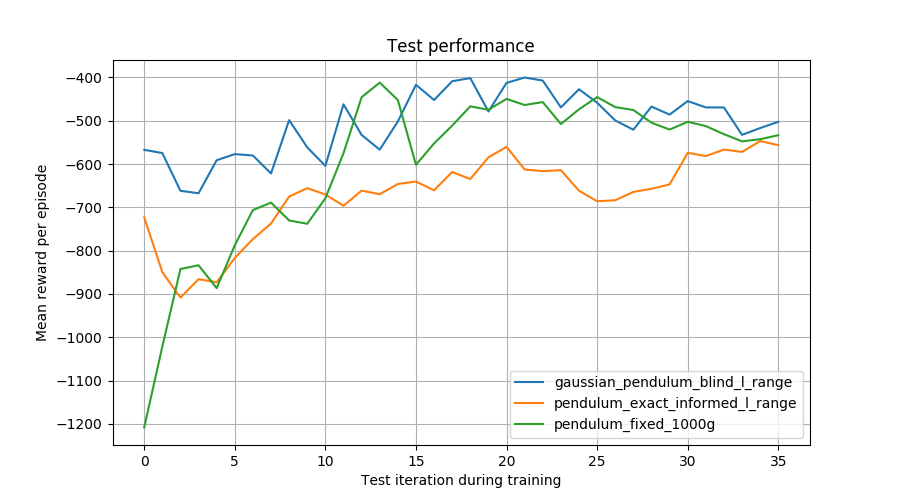

In [24]:
compare_test_results('set6', conf_intervals=False, highest=False)

### Test performance by mass

<IPython.core.display.Javascript object>


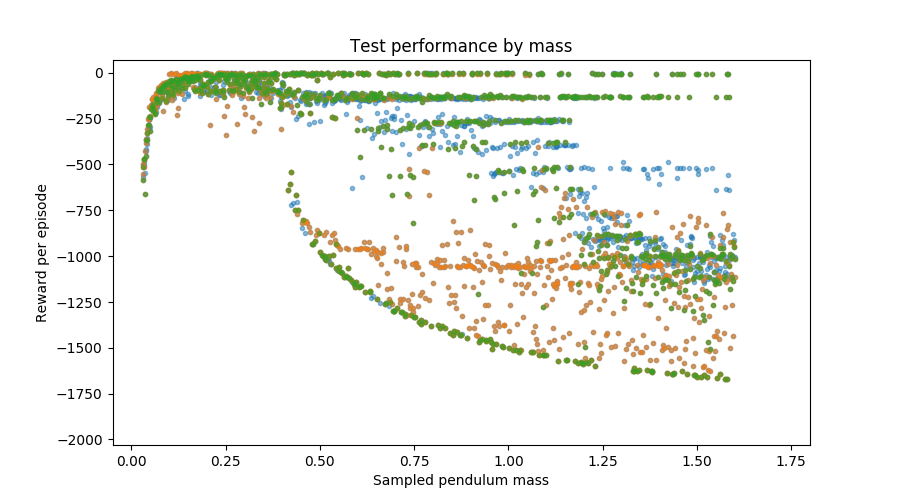

gaussian_pendulum_blind_l_range


<IPython.core.display.Javascript object>


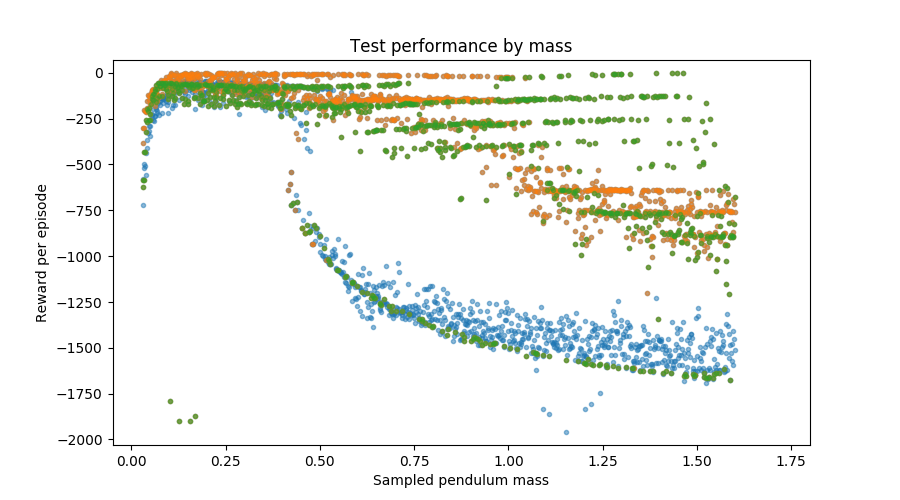

pendulum_exact_informed_l_range


<IPython.core.display.Javascript object>


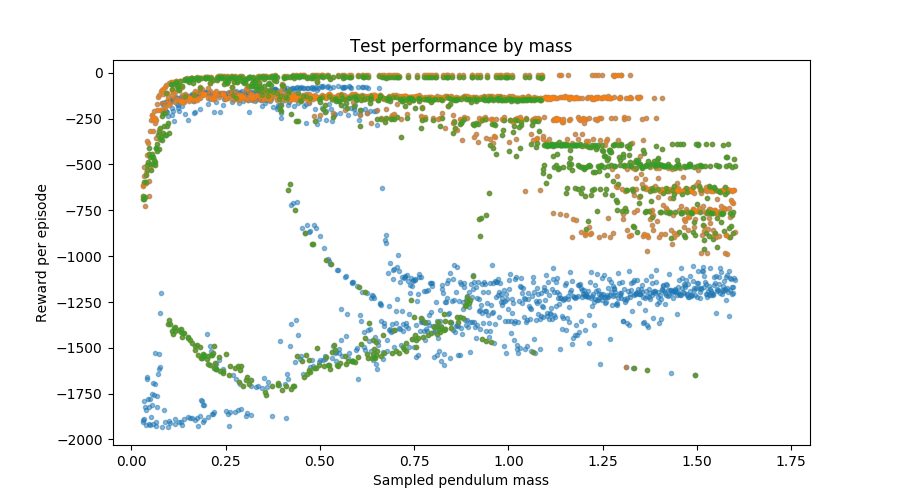

pendulum_fixed_1000g


In [23]:
for i, k in enumerate(set6_results.keys()):
    plot_rewards_by_mass(
        set6_test_results[k].reshape(-1, 4),
        color=set6_colors[i],
        resample=False,
        #marker_cycle=[".", "^", "*"],
        marker_cycle=["."],
        color_cycle=set6_colors,
        cycle_len=1000
    )
    print(k)